# Step1: Importing Data and Libraries

In [41]:
!git clone https://github.com/bardiarms/gan-rl.git
%cd gan-rl

Cloning into 'gan-rl'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 37 (delta 17), reused 26 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 157.78 KiB | 1.73 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/gan-rl/gan-rl


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# %%bash
# DRIVE_DATA="/content/drive/MyDrive/gan-rl-data/cartoonset100k"
# LOCAL_DATA="/content/cartoonset100k"

# # Copy only once per session
# if [ -d "$LOCAL_DATA" ] && [ "$(ls -A "$LOCAL_DATA" | wc -l)" -gt 0 ]; then
#   echo "Local dataset already exists at $LOCAL_DATA"
# else
#   echo "Copying dataset to local disk..."
#   rsync -ah --info=progress2 "$DRIVE_DATA/" "$LOCAL_DATA/"
# fi

# echo "Local dataset size:"
# du -sh "$LOCAL_DATA"

In [43]:
!pip install torch torchvision torchaudio tqdm matplotlib pandas pillow

In [44]:
DATA_DIR = "/content/drive/MyDrive/gan-rl-data"
RUN_DIR  = "/content/drive/MyDrive/gan-rl-runs"

In [45]:
!ls -la "$DATA_DIR"

total 499760
lrw------- 1 root root         0 Dec 19 11:37 cartoonset100k -> /content/drive/.shortcut-targets-by-id/1l-9xzrKNZUKfWTFGh0SRZe9j1HKLRRqJ/cartoonset100k
-rw------- 1 root root 511754240 Dec 22 07:50 cartoonset100k.tar


In [46]:
REPO_DIR = "/content/gan-rl"

In [47]:
import os

In [48]:
os.makedirs(RUN_DIR, exist_ok=True)
print("DATA_DIR exists:", os.path.exists(DATA_DIR))
print("RUN_DIR:", RUN_DIR)

DATA_DIR exists: True
RUN_DIR: /content/drive/MyDrive/gan-rl-runs


In [49]:
# DATA_ROOT = "/content/cartoonset100k"
DATA_ROOT = "/content/drive/MyDrive/gan-rl-data/cartoonset100k"

# Step2: Data Preprocessing

### Enumerate image-metadata paris

In [50]:
from pathlib import Path


In [51]:
data_root = Path(DATA_ROOT)

pairs, missing_meta, missing_img = [], [], []

for d in sorted(data_root.iterdir()):

    for png_path in d.glob("*.png"):
        csv_path = png_path.with_suffix(".csv")
        if csv_path.exists():
            pairs.append((str(png_path), str(csv_path), int(d.name)))   # If the pair exists, add them to pairs
        else:
            missing_meta.append(str(png_path))


print("Total pairs:", len(pairs))
print("Missing CSV for PNG:", len(missing_meta))

Total pairs: 100000
Missing CSV for PNG: 17


In [52]:
for i in range(5):
    print(pairs[i])

('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12694632614924764393.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12694632614924764393.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12110888894984629978.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12110888894984629978.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12783151780612292884.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs12783151780612292884.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1182038763634098519.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1182038763634098519.csv', 0)
('/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1213446833171185255.png', '/content/drive/MyDrive/gan-rl-data/cartoonset100k/0/cs1213446833171185255.csv', 0)


In [53]:
pairs.sort(key=lambda x: x[0])  # sort by image path

In [54]:
# Assert we can open the first image + read first metadata line
from PIL import Image
import pandas as pd

img_path, meta_path, folder_id = pairs[0]
img = Image.open(img_path).convert("RGB")
df = pd.read_csv(meta_path, header=None, names=["attr", "value", "max"])

print("Sample folder:", folder_id)
print("Image size:", img.size)
print("Metadata shape:", df.shape)
print(df.head())

Sample folder: 0
Image size: (500, 500)
Metadata shape: (18, 3)
             attr  value  max
0       eye_angle      2    3
1      eye_lashes      1    2
2         eye_lid      1    2
3     chin_length      0    3
4  eyebrow_weight      0    2


In [55]:
# Read one metadata file
def read_meta_csv(meta_path: str) -> pd.DataFrame:
    df = pd.read_csv(meta_path, header=None, names=["attr", "value", "max"])
    # ensure types
    df["attr"] = df["attr"].astype(str)
    df["value"] = df["value"].astype(int)
    df["max"] = df["max"].astype(int)
    return df

In [56]:
# Buil a schema for one-hot encoding
def build_schema(pairs, max_files=20):
    # pairs: list of (img_path, meta_path, folder_id)
    attr_to_num_classes = {}  # attr -> (max+1)
    attr_order = []           # stable order of attrs as discovered

    for i, (_, meta_path, _) in enumerate(pairs[:max_files]):
        df = read_meta_csv(meta_path)
        for _, row in df.iterrows():
            attr = row["attr"]
            num_classes = row["max"] + 1

            if attr not in attr_to_num_classes:
                attr_to_num_classes[attr] = num_classes
                attr_order.append(attr)
            else:
                # keep the maximum seen (in case some files differ)
                attr_to_num_classes[attr] = max(attr_to_num_classes[attr], num_classes)

    # offsets for packing one big vector
    offsets = {}
    total_dim = 0
    for attr in attr_order:
        offsets[attr] = total_dim
        total_dim += attr_to_num_classes[attr]

    return attr_order, attr_to_num_classes, offsets, total_dim

In [57]:
attr_order, attr_to_num_classes, offsets, meta_dim = build_schema(pairs)
print("num attributes:", len(attr_order))
print("meta vector dim:", meta_dim)
print(attr_order[:])

num attributes: 18
meta vector dim: 235
['eye_angle', 'eye_lashes', 'eye_lid', 'chin_length', 'eyebrow_weight', 'eyebrow_shape', 'eyebrow_thickness', 'face_shape', 'facial_hair', 'hair', 'eye_color', 'face_color', 'hair_color', 'glasses', 'glasses_color', 'eye_slant', 'eyebrow_width', 'eye_eyebrow_distance']


In [58]:
# Freeze the schema (Run Once)

import json

schema = {
    "attr_order": attr_order,
    "attr_to_num_classes": attr_to_num_classes,
    "offsets": offsets,
    "total_dim": meta_dim,
}

SCHEMA_PATH = "/content/drive/MyDrive/gan-rl-runs/meta_schema.json"
os.makedirs(os.path.dirname(SCHEMA_PATH), exist_ok=True)

with open(SCHEMA_PATH, "w") as f:
    json.dump(schema, f, indent=2)

print("Saved:", SCHEMA_PATH)

Saved: /content/drive/MyDrive/gan-rl-runs/meta_schema.json


### Resizing and normalization

In [59]:
from torchvision import transforms

In [60]:

IMG_SIZE = 128      # We convert 500*500 pixel images into 128*128.
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

In [61]:
import torch
import numpy as np

In [62]:
# Read metadata and store them in pandas dataframe
def read_meta(meta_path: str)-> pd.DataFrame:

  df = pd.read_csv(meta_path, header=None, names=["attr", "value", "max"])
  df["attr"] = df["attr"].astype(str)
  df["value"] = df["value"].astype(int)
  df["max"] = df["max"].astype(int)

  return df

In [63]:
# Apply one-hot encoding
def encode_onehot(meta_path: str,
                  attr_to_num_classes: dict,
                  offsets: dict,
                  total_dim: int
                  )-> torch.Tensor:

    df = read_meta(meta_path)
    vec = np.zeros((total_dim,), dtype=np.float32)

    for _, row in df.iterrows():
        attr = row["attr"]
        val = int(row["value"])

        if attr not in offsets:
          continue

        n = attr_to_num_classes[attr]
        if val < 0 or val >= n:
            val = max(0, min(val, n - 1))

        vec[offsets[attr] + val] = 1.0

    return torch.from_numpy(vec)


In [25]:
# Cache one-hot vectors to increase computation speed
# meta_cache = {}
# for _, meta_path, _ in pairs:
#     if meta_path not in meta_cache:
#         meta_cache[meta_path] = encode_onehot(
#             meta_path,
#             attr_to_num_classes=attr_to_num_classes,
#             offsets=offsets,
#             total_dim=meta_dim
#         )
# print("✅ Cached metadata vectors:", len(meta_cache))

### Create Dataset (image, metadata one-hot)

In [64]:
from torch.utils.data import Dataset

In [65]:
class CartoonSetDataset(Dataset):

    def __init__(self, pairs, img_transform, meta_cache = None):
        self.pairs = pairs
        self.img_transform = img_transform
        self.meta_cache = meta_cache

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, meta_path, folder_id = self.pairs[idx]

        img = Image.open(img_path).convert("RGB")
        img = self.img_transform(img)

        if self.meta_cache is not None:
            meta = self.meta_cache[meta_path]
            return img, meta, folder_id

        else:
            return img, folder_id



### Build Dataloader

In [66]:
from torch.utils.data import DataLoader

In [ ]:
ds = CartoonSetDataset(pairs=pairs, img_transform=img_transform)

dl = DataLoader(
    ds,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)
imgs, folder_ids = next(iter(dl))
print("imgs:", imgs.shape, imgs.min().item(), imgs.max().item())
#print("metas:", metas.shape, metas.min().item(), metas.max().item())
print("folder_ids:", folder_ids[:8])
#print("meta sums (first 8):", metas[:8].sum(dim=1))

imgs: torch.Size([16, 3, 128, 128]) -1.0 1.0
folder_ids: tensor([8, 5, 8, 6, 6, 8, 4, 6])


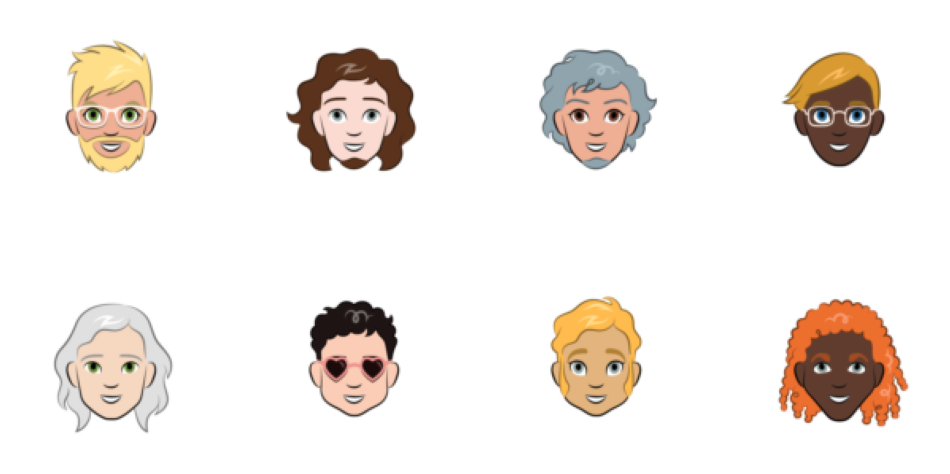

In [68]:
# Visualize a few images
import matplotlib.pyplot as plt

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

x = denorm(imgs[:8])

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x[i].permute(1,2,0))
    plt.axis("off")
plt.show()

In [ ]:
import torch
import torch.nn as nn
from src import models
IMG_SIZE = 128
Z_DIM = 128
BATCH_SIZE = 4
DEVICE = "cuda"
criterion = nn.BCEWithLogitsLoss()

In [70]:
G = models.Generator(z_dim=Z_DIM).to(DEVICE)
D = models.Discriminator().to(DEVICE)

imgs, folder_ids = next(iter(dl))  # from your existing DataLoader
imgs = imgs.to(DEVICE)

z = torch.randn(imgs.size(0), Z_DIM, device=DEVICE)
fake = G(z)

print("Real:", imgs.shape, imgs.min().item(), imgs.max().item())
print("Fake:", fake.shape, fake.min().item(), fake.max().item())

d_real = D(imgs)
d_fake = D(fake.detach())

print("D(real) shape:", d_real.shape, "min/max:", d_real.min().item(), d_real.max().item())
print("D(fake) shape:", d_fake.shape, "min/max:", d_fake.min().item(), d_fake.max().item())

Real: torch.Size([16, 3, 128, 128]) -1.0 1.0
Fake: torch.Size([16, 3, 128, 128]) -0.999531090259552 0.9999703764915466
D(real) shape: torch.Size([16]) min/max: -0.07257905602455139 -0.00740415696054697
D(fake) shape: torch.Size([16]) min/max: -0.019641894847154617 0.04509039968252182


In [71]:
lr = 2e-4
beta1, beta2 = 0.5, 0.999

opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

use_amp = True
scaler = torch.amp.GradScaler(device="cuda", enabled=use_amp)


/tmp/ipython-input-73855047.py:8: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = torch.amp.GradScaler(device="cuda", enabled=use_amp)


In [72]:
G.train(); D.train()

imgs, folder_ids = next(iter(dl))
real = imgs.to(DEVICE)
B = real.size(0)

# labels
real_labels = torch.ones(B, device=DEVICE)
fake_labels = torch.zeros(B, device=DEVICE)

#   ---Train Discriminator---
opt_D.zero_grad(set_to_none=True)
with torch.amp.autocast(device_type="cuda", enabled=use_amp):

    fake = G(z)

    logits_real = D(real)
    logits_fake = D(fake.detach())

    loss_D_real = criterion(logits_real, real_labels)
    loss_D_fake = criterion(logits_fake, fake_labels)
    loss_D = loss_D_real + loss_D_fake

if use_amp:
  scaler.scale(loss_D).backward()
  scaler.step(opt_D)

else:
  loss_D.backward()
  opt_D.step()

# ---Train Generator---
opt_G.zero_grad(set_to_none=True)

z = torch.randn(B, Z_DIM, device=DEVICE)
with torch.amp.autocast(device_type="cuda", enabled=use_amp):
    fake = G(z)
    logits_fake_for_G = D(fake)
    loss_G = criterion(logits_fake_for_G, real_labels)

if use_amp:
    scaler.scale(loss_G).backward()
    scaler.step(opt_G)
    scaler.update()
else:
    loss_G.backward()
    opt_G.step()

print(
    f"loss_D: {loss_D.item():.4f} (real {loss_D_real.item():.4f}, fake {loss_D_fake.item():.4f}) | "
    f"loss_G: {loss_G.item():.4f} | "
    f"D(real) mean: {logits_real.mean().item():.3f} | D(fake) mean: {logits_fake.mean().item():.3f}"
)



/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


loss_D: 1.3972 (real 0.7020, fake 0.6952) | loss_G: 0.7590 | D(real) mean: -0.018 | D(fake) mean: 0.004


### Train for a few iterations

In [73]:
from torchvision.utils import make_grid, save_image

In [75]:
# RUN_DIR = "/content/drive/MyDrive/gan-rl-runs"
# SAMPLES_DIR = os.path.join(RUN_DIR, "samples_128")
# CKPT_DIR = os.path.join(RUN_DIR, "checkpoints_128")
# os.makedirs(SAMPLES_DIR, exist_ok=True)
# os.makedirs(CKPT_DIR, exist_ok=True)


# Denormalize pixels for viewing
def denorm(x):
    return (x * 0.5 + 0.5).clamp(0, 1)

@torch.no_grad()
def save_samples(G, step, fixed_z, out_dir, nrow=8):
    G.eval()
    fake = G(fixed_z)
    grid = make_grid(denorm(fake), nrow=nrow)
    path = os.path.join(out_dir, f"step_{step:06d}.png")
    save_image(grid, path)
    G.train()



In [ ]:
# MAX_STEPS = 300
# SAMPLE_EVERY = 50
# CKPT_EVERY = 200

In [ ]:

# fixed_z = torch.randn(64, Z_DIM, device=DEVICE)

# G.train(); D.train()

# step = 0
# data_iter = iter(dl)

# while step < MAX_STEPS:
#     try:
#         imgs, folder_ids = next(data_iter)
#     except StopIteration:
#         data_iter = iter(dl)
#         imgs, folder_ids = next(data_iter)

#     real = imgs.to(DEVICE, non_blocking=True)
#     B = real.size(0)

#     real_labels = torch.ones(B, device=DEVICE)
#     fake_labels = torch.zeros(B, device=DEVICE)


#     # ---Train Discriminator---

#     opt_D.zero_grad(set_to_none=True)
#     z = torch.randn(B, Z_DIM, device=DEVICE)

#     with torch.amp.autocast(device_type="cuda", enabled=use_amp):
#         fake = G(z)
#         logits_real = D(real)
#         logits_fake = D(fake.detach())
#         loss_D_real = criterion(logits_real, real_labels)
#         loss_D_fake = criterion(logits_fake, fake_labels)
#         loss_D = loss_D_real + loss_D_fake

#     scaler.scale(loss_D).backward()
#     scaler.step(opt_D)

#     # -------------------------
#     # Train Generator
#     # -------------------------
#     opt_G.zero_grad(set_to_none=True)
#     z = torch.randn(B, Z_DIM, device=DEVICE)

#     with torch.amp.autocast(device_type="cuda", enabled=use_amp):
#         fake = G(z)
#         logits_fake_for_G = D(fake)
#         loss_G = criterion(logits_fake_for_G, real_labels)

#     scaler.scale(loss_G).backward()
#     scaler.step(opt_G)
#     scaler.update()

#     # Logging
#     if step % 10 == 0:
#         print(
#             f"step {step:04d} | "
#             f"loss_D {loss_D.item():.4f} (r {loss_D_real.item():.4f}, f {loss_D_fake.item():.4f}) | "
#             f"loss_G {loss_G.item():.4f} | "
#             f"D(real) {logits_real.mean().item():+.3f} | D(fake) {logits_fake.mean().item():+.3f}"
#         )

#     # Save samples
#     if step % SAMPLE_EVERY == 0:
#         save_samples(G, step, fixed_z)

#     # Save checkpoints (optional)
#     if step > 0 and step % CKPT_EVERY == 0:
#         ckpt_path = os.path.join(CKPT_DIR, f"gan_step_{step:06d}.pt")
#         torch.save(
#             {
#                 "step": step,
#                 "G": G.state_dict(),
#                 "D": D.state_dict(),
#                 "opt_G": opt_G.state_dict(),
#                 "opt_D": opt_D.state_dict(),
#                 "scaler": scaler.state_dict(),
#             },
#             ckpt_path,
#         )

#     step += 1

In [ ]:
def train_func(RUN_DIR: str,
               iters: int,
               SAMPLE_EVERY: int,
               CHKPT_EVERY: int
               )-> None:

    SAMPLES_DIR = os.path.join(RUN_DIR, f"samples_128_{iters}_iters")
    CHKPT_DIR = os.path.join(RUN_DIR, f"checkpoints_128_{iters}_iters")
    os.makedirs(SAMPLES_DIR, exist_ok=True)
    os.makedirs(CHKPT_DIR, exist_ok=True)

    fixed_z = torch.randn(64, Z_DIM, device=DEVICE)

    G.train(); D.train()

    step = 0
    data_iter = iter(dl)

    while step < iters:
        try:
            imgs, folder_ids = next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            imgs, folder_ids = next(data_iter)

        real = imgs.to(DEVICE, non_blocking=True)
        B = real.size(0)

        real_labels = torch.ones(B, device=DEVICE)
        fake_labels = torch.zeros(B, device=DEVICE)


        # ---Train Discriminator---

        opt_D.zero_grad(set_to_none=True)
        z = torch.randn(B, Z_DIM, device=DEVICE)

        with torch.amp.autocast(device_type="cuda", enabled=use_amp):
            fake = G(z)
            logits_real = D(real)
            logits_fake = D(fake.detach())
            loss_D_real = criterion(logits_real, real_labels)
            loss_D_fake = criterion(logits_fake, fake_labels)
            loss_D = loss_D_real + loss_D_fake

        scaler.scale(loss_D).backward()
        scaler.step(opt_D)

        # -------------------------
        # Train Generator
        # -------------------------
        opt_G.zero_grad(set_to_none=True)
        z = torch.randn(B, Z_DIM, device=DEVICE)

        with torch.amp.autocast(device_type="cuda", enabled=use_amp):
            fake = G(z)
            logits_fake_for_G = D(fake)
            loss_G = criterion(logits_fake_for_G, real_labels)

        scaler.scale(loss_G).backward()
        scaler.step(opt_G)
        scaler.update()

        # Logging
        if step % 10 == 0:
            print(
                f"step {step:04d} | "
                f"loss_D {loss_D.item():.4f} (r {loss_D_real.item():.4f}, f {loss_D_fake.item():.4f}) | "
                f"loss_G {loss_G.item():.4f} | "
                f"D(real) {logits_real.mean().item():+.3f} | D(fake) {logits_fake.mean().item():+.3f}"
            )

        # Save samples
        if step % SAMPLE_EVERY == 0:
            save_samples(G, step, fixed_z, out_dir = SAMPLES_DIR)

        # Save checkpoints (optional)
        if step > 0 and step % CHKPT_EVERY == 0:
            ckpt_path = os.path.join(CHKPT_DIR, f"gan_step_{step:06d}.pt")
            torch.save(
                {
                    "step": step,
                    "G": G.state_dict(),
                    "D": D.state_dict(),
                    "opt_G": opt_G.state_dict(),
                    "opt_D": opt_D.state_dict(),
                    "scaler": scaler.state_dict(),
                },
                ckpt_path,
            )

        step += 1


In [78]:
train_func(RUN_DIR = "/content/drive/MyDrive/gan-rl-runs/12000_iters", iters = 12000, SAMPLE_EVERY = 500, CHKPT_EVERY = 500)

step 0000 | loss_D 1.1757 (r 0.3248, f 0.8508) | loss_G 1.0930 | D(real) +0.958 | D(fake) +0.294
step 0010 | loss_D 0.0023 (r 0.0000, f 0.0023) | loss_G 6.9677 | D(real) +12.827 | D(fake) -6.097


KeyboardInterrupt: 